In [1]:
!pip install --upgrade shapely

In [2]:
import geopandas as gpd

lsoa_path = 'Data/GIS/LSOA/LSOA_2011_London_gen_MHW.shp'
lsoa = gpd.read_file(lsoa_path)
lsoa = lsoa.to_crs(epsg=27700)

print("New CRS:", lsoa.crs)

New CRS: EPSG:27700


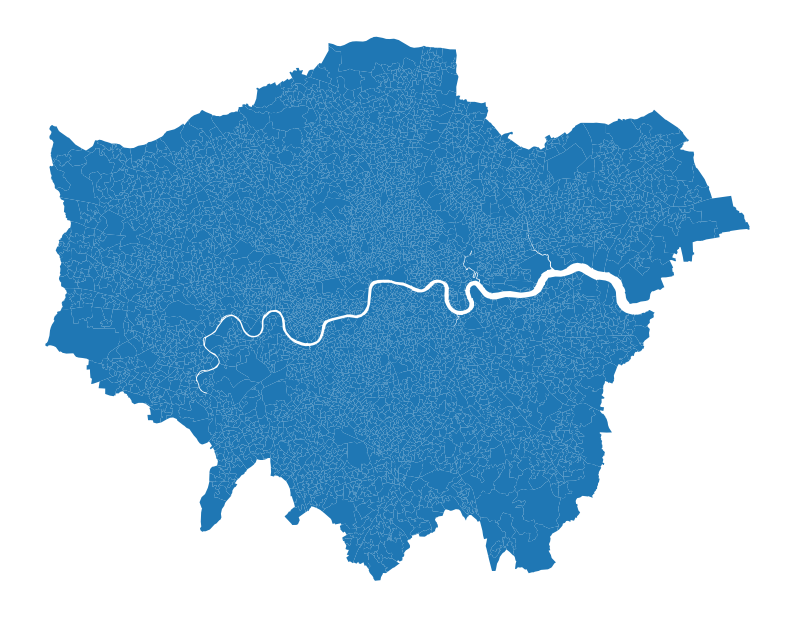

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
lsoa.plot(ax=ax)
ax.set_axis_off()
plt.show()

In [6]:
caz = gpd.read_file('Data/GIS/CAZ/Central_Activities_Zone.gpkg')
print("Original CRS:", caz.crs)

caz = caz.to_crs(epsg=27700)
print("New CRS:", caz.crs)

Original CRS: PROJCS["unnamed",GEOGCS["Airy 1830",DATUM["unknown",SPHEROID["airy",6377563.396,299.324975315035],EXTENSION["PROJ4_GRIDS","Q:\Temp\yw\ostn02-ntv2-data\OSTN02_NTv2.gsb"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New CRS: EPSG:27700


<Axes: >

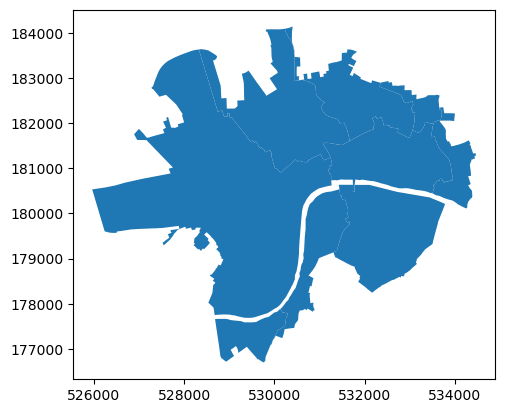

In [7]:
caz.plot()

In [8]:
boros = gpd.read_file('Data/GIS/Borough/London_Borough_Excluding_MHW.shp')
print("Original CRS:", boros.crs)

boros = boros.to_crs(epsg=27700)
print("New CRS:", boros.crs)

Original CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New CRS: EPSG:27700


In [9]:
inner_boros = boros[boros['ONS_INNER'] == 'T']

<Axes: >

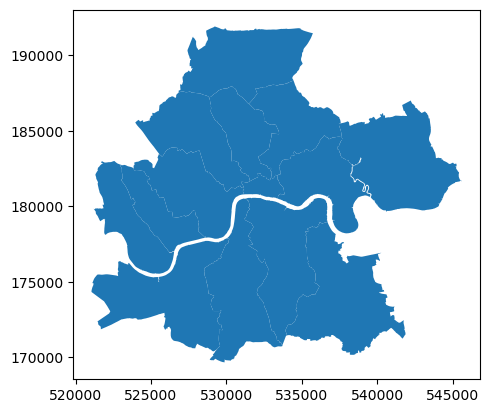

In [10]:
inner_boros.plot()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_3654/1706424299.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


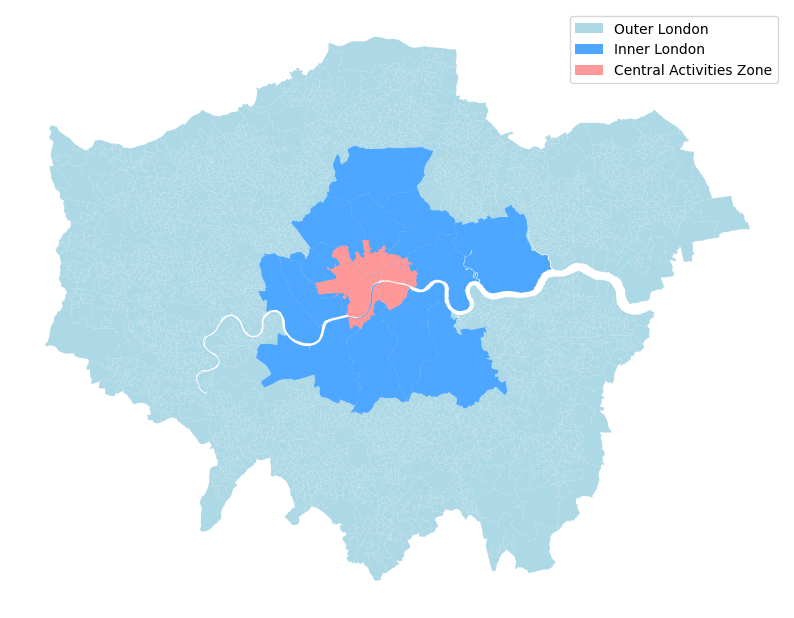

In [11]:
caz["label"] = "Central Activities Zone"
inner_boros["label"] = "Inner London"
lsoa["label"] = "Outer London"

fig, ax = plt.subplots(figsize=(10, 10))

lsoa.plot(ax=ax, color='#add8e6', linewidth=0, label='Outer London')
inner_boros.plot(ax=ax, color='#4da6ff', linewidth=0, label='Inner London')
caz.plot(ax=ax, color='#ff9999', linewidth=0, edgecolor='black', label='Central Activities Zone')

ax.axis('off')
ax.legend()

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#add8e6', label='Outer London'),
    Patch(facecolor='#4da6ff', label='Inner London'),
    Patch(facecolor='#ff9999', label='Central Activities Zone')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

In [12]:
from shapely.geometry import Point

lsoa = lsoa.to_crs(caz.crs)
lsoa_centroids = lsoa.geometry.centroid

# Combine all CAZ polygons into a single geometry
caz_union = caz.unary_union
inner_boros_union = inner_boros.unary_union

# Create the new boolean column: 1 if centroid is within CAZ, else 0
lsoa["caz"] = lsoa.geometry.intersects(caz_union).astype(int)
lsoa["inner"] = lsoa.geometry.intersects(inner_boros_union).astype(int)

/tmp/ipykernel_3654/635959943.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  caz_union = caz.unary_union
/tmp/ipykernel_3654/635959943.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  inner_boros_union = inner_boros.unary_union


In [13]:
# Tier 1: CAZ only
tier1 = lsoa[(lsoa['inner'] == 1) & (lsoa['caz'] == 1)]
print("Tier 1 count:", len(tier1))
tier1 = tier1.copy()
tier1['tier'] = 'Tier 1'

# Tier 2: Inner only (but not CAZ)
tier2 = lsoa[(lsoa['inner'] == 1) & (lsoa['caz'] == 0)]
print("Tier 2 count:", len(tier2))
tier2 = tier2.copy()
tier2['tier'] = 'Tier 2'

# Tier 3: Neither
tier3 = lsoa[(lsoa['inner'] == 0) & (lsoa['caz'] == 0)]
print("Tier 3 count:", len(tier3))
tier3 = tier3.copy()
tier3['tier'] = 'Tier 3'

Tier 1 count: 210
Tier 2 count: 1822
Tier 3 count: 2803


In [14]:
stations = gpd.read_file('Data/GIS/TfL/tfl_stations.json')
stations = stations.to_crs(epsg = 27700)

In [15]:
import re

station_names = {row.id: row['name'] for i, row in stations.iterrows()}

for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])
cleaned_name_map = stations.set_index('id')['name'].to_dict()

In [16]:
import ast

# Safely parse string representations into actual Python lists
stations["parsed_lines"] = stations["lines"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

unique_names = set()

for lines in stations["parsed_lines"]:
    if isinstance(lines, list):
        for item in lines:
            if isinstance(item, dict) and "name" in item:
                unique_names.add(item["name"])

print(sorted(unique_names))

['Bakerloo', 'Central', 'Circle', 'Crossrail', 'Crossrail 2', 'DLR', 'District', 'East London', 'Emirates Air Line', 'Hammersmith & City', 'Jubilee', 'London Overground', 'Metropolitan', 'National Rail', 'Northern', 'Piccadilly', 'TfL Rail', 'Tramlink', 'Victoria', 'Waterloo & City']


In [17]:
# Define filter function
def has_crossrail(lines):
    if isinstance(lines, list):
        return any(d.get("name") == "Crossrail" for d in lines)
    return False

crossrail_stations = stations[stations['parsed_lines'].apply(has_crossrail)]
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
449          Liverpool Street   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
465                Paddington   
466                Paddington   
473                   Reading   
474       

In [18]:
# Figure out whether the two "Liverpool Stations" are duplicate entries
liverpool_stations = stations[stations["name"] == "Liverpool Street"]
print(liverpool_stations)

# Check if geometries are identical
geometries_equal = liverpool_stations.geometry.iloc[0].equals(liverpool_stations.geometry.iloc[1])
print("\nSame geometry:", geometries_equal)

              id              name nlc_id  \
138  940GZZLULVT  Liverpool Street   0634   
449    910GLIVST  Liverpool Street   6965   
450  910GLIVSTLL  Liverpool Street   None   

                                                 lines  \
138  [ { "name": "Central", "nightopened": 2016 }, ...   
449  [ { "name": "London Overground", "opened": 201...   
450        [ { "name": "Crossrail", "opened": 2018 } ]   

                                           cartography altmodeid alt_id  \
138                      { "labelX": 1, "labelY": 45 }      None    157   
449  { "labelX": 1, "labelY": 45, "display_name": "...      None    LST   
450  { "labelX": -1, "labelY": -45, "display_name":...      None   None   

    altmodeid2 zone                       geometry  \
138       None    1  POINT (533092.226 181560.876)   
449       None    1   POINT (533264.24 181654.408)   
450       None    1   POINT (533021.42 181648.039)   

                                          parsed_lines  
138  [{'nam

In [19]:
crossrail_stations = crossrail_stations.drop(index=449)
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
465                Paddington   
466                Paddington   
473                   Reading   
474                   Romford   
480       

In [20]:
# Figure out whether the two "Paddington Stations" are duplicate entries
paddington_stations = stations[stations["name"] == "Paddington"]
print(paddington_stations)

# Check if geometries are identical
geometries_equal = paddington_stations.geometry.iloc[0].equals(paddington_stations.geometry.iloc[1])
print("\nSame geometry:", geometries_equal)

              id        name  nlc_id  \
171  940GZZLUPAC  Paddington    0670   
172  940GZZLUPAH  Paddington    3087   
465   910GPADTLL  Paddington    None   
466   910GPADTON  Paddington  308700   

                                                 lines  \
171  [ { "name": "Bakerloo" }, { "name": "District"...   
172  [ { "name": "Hammersmith & City" }, { "name": ...   
465        [ { "name": "Crossrail", "opened": 2018 } ]   
466  [ { "name": "Crossrail", "opened": 2018, "clos...   

                                           cartography altmodeid alt_id  \
171     { "labelX": 30, "display_name": "Paddington" }      None   None   
172  { "labelX": 1, "labelY": -30, "display_name": ...      None    193   
465  { "labelX": -25, "labelY": 20, "display_name":...      None   None   
466  { "labelX": -25, "labelY": 20, "display_name":...      None    PAD   

    altmodeid2 zone                       geometry  \
171       None    1  POINT (526763.197 181249.357)   
172       None    1  POI

In [21]:
crossrail_stations = crossrail_stations.drop(index=465)
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
466                Paddington   
473                   Reading   
474                   Romford   
480                 Shenfield   
485       

In [22]:
lsoa_union = lsoa.unary_union
crossrail_stations = crossrail_stations[crossrail_stations.geometry.within(lsoa_union)].copy()

/tmp/ipykernel_3654/3970372433.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lsoa_union = lsoa.unary_union


In [23]:
crossrail_stations["caz"] = crossrail_stations.geometry.intersects(caz_union).astype(int)
crossrail_stations["inner"] = crossrail_stations.geometry.intersects(inner_boros_union).astype(int)

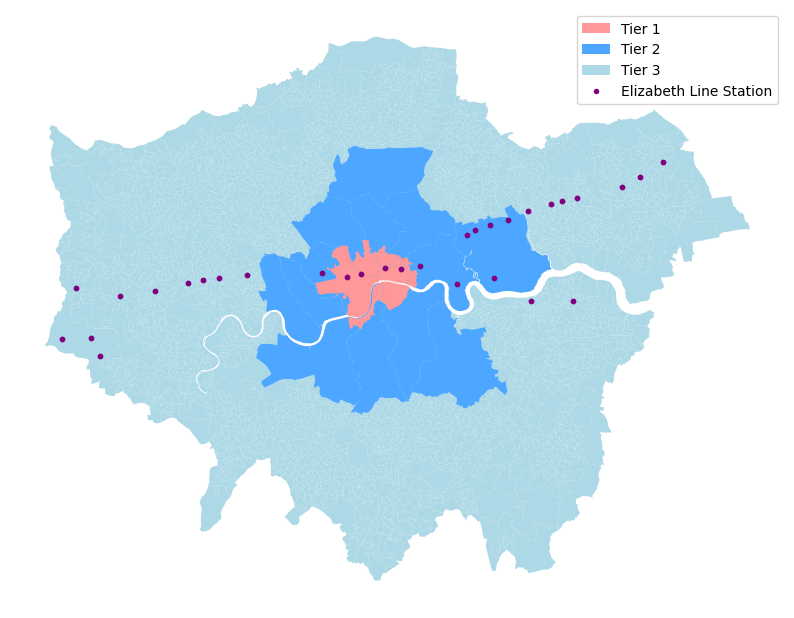

In [24]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 10))

lsoa.plot(ax=ax, color='#add8e6', linewidth=0)
inner_boros.plot(ax=ax, color='#4da6ff', linewidth=0, edgecolor='black')
caz.plot(ax=ax, color='#ff9999', linewidth=0, edgecolor='black')
crossrail_stations.plot(ax=ax, color='purple', markersize=10, label='Elizabeth Line Station')

ax.axis('off')

legend_elements = [
    Patch(facecolor='#ff9999', label='Tier 1'),
    Patch(facecolor='#4da6ff', label='Tier 2'),
    Patch(facecolor='#add8e6', label='Tier 3'),
    Line2D([0], [0], marker='o', color='w', label='Elizabeth Line Station',
           markerfacecolor='purple', markersize=5)
]

ax.legend(handles=legend_elements, loc='upper right')
plt.show()

In [25]:
import glob
import pandas as pd

In [26]:
file_paths_hts = glob.glob('Data/BRES/M/M_*.csv')  # updated pattern
hts_data_frames = {}
failed_files = {}

for file_path in file_paths_hts:
    # Extract the year from filenames like 'KI_2009.csv'
    year = file_path.rsplit("/", 1)[-1].replace("M_", "").replace(".csv", "")
    
    try:
        # Read with comma separator
        df = pd.read_csv(file_path, sep=',', engine='python', on_bad_lines='skip')
        
        # Drop completely empty columns
        df = df.dropna(axis=1, how='all')

        # Convert numerics where possible
        df = df.apply(pd.to_numeric, errors='ignore')

        # Report and drop rows with NaNs
        n_with_nan = df.isna().any(axis=1).sum()
        print(f"{year}: {n_with_nan} rows with ≥1 NaN")
        original_rows = len(df)
        df = df.dropna()
        dropped = original_rows - len(df)
        print(f"{year}: {dropped} rows dropped, {len(df)} rows kept")

        hts_data_frames[year] = df

    except Exception as e:
        print(f"❌ Failed to load {file_path}: {e}")  # ✅ show real reason
        failed_files[year] = str(e)


print("\n Years loaded:", sorted(hts_data_frames.keys()))
print("Years failed:", sorted(failed_files.keys()))


/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2016: 6 rows with ≥1 NaN
2016: 6 rows dropped, 4835 rows kept
2017: 6 rows with ≥1 NaN
2017: 6 rows dropped, 4835 rows kept


/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2015: 6 rows with ≥1 NaN
2015: 6 rows dropped, 4835 rows kept
2014: 5 rows with ≥1 NaN
2014: 5 rows dropped, 4766 rows kept
2010: 5 rows with ≥1 NaN
2010: 5 rows dropped, 4766 rows kept
2011: 5 rows with ≥1 NaN
2011: 5 rows dropped, 4766 rows kept


/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykern

2013: 5 rows with ≥1 NaN
2013: 5 rows dropped, 4766 rows kept
2012: 5 rows with ≥1 NaN
2012: 5 rows dropped, 4766 rows kept
2023: 6 rows with ≥1 NaN
2023: 6 rows dropped, 4835 rows kept
2022: 6 rows with ≥1 NaN
2022: 6 rows dropped, 4835 rows kept
2020: 6 rows with ≥1 NaN
2020: 6 rows dropped, 4835 rows kept
2009: 5 rows with ≥1 NaN
2009: 5 rows dropped, 4766 rows kept
2021: 6 rows with ≥1 NaN
2021: 6 rows dropped, 4835 rows kept
2019: 6 rows with ≥1 NaN
2019: 6 rows dropped, 4835 rows kept
2018: 6 rows with ≥1 NaN
2018: 6 rows dropped, 4835 rows kept

 Years loaded: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Years failed: []


/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_3654/1805763183.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [27]:
for year, df in hts_data_frames.items():
    # Safely extract the last 4 digits, assuming they're the year
    year_int = int(year[-4:])

    geo_key = 'LSOA01CD' if year_int <= 2014 else 'LSOA11CD'

    numeric_cols = [
        col for col in df.columns
        if col not in [geo_key, 'inner_outer'] 
        and pd.api.types.is_numeric_dtype(df[col])
        and not col.startswith('Unnamed')
    ]

    df['total'] = df[numeric_cols].sum(axis=1)
    hts_data_frames[year] = df

In [28]:
hts_2009 = hts_data_frames["2009"]
hts_2010 = hts_data_frames["2010"]
hts_2011 = hts_data_frames["2011"]
hts_2012 = hts_data_frames["2012"]
hts_2013 = hts_data_frames["2013"]
hts_2014 = hts_data_frames["2014"]
hts_2015 = hts_data_frames["2015"]
hts_2016 = hts_data_frames["2016"]
hts_2017 = hts_data_frames["2017"]
hts_2018 = hts_data_frames["2018"]
hts_2019 = hts_data_frames["2019"]
hts_2020 = hts_data_frames["2020"]
hts_2021 = hts_data_frames["2021"]
hts_2022 = hts_data_frames["2022"]
hts_2023 = hts_data_frames["2023"]

In [29]:
from IPython.display import display

for year, df in sorted(hts_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== 2009 =====
Shape: (4766, 5)
Dtypes:
 2001 super output areas - lower layer                                                 object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2001 super output areas - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2010 =====
Shape: (4766, 5)
Dtypes:
 2001 super output areas - lower layer                                                 object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2001 super output areas - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2011 =====
Shape: (4766, 5)
Dtypes:
 2001 super output areas - lower layer                                                 object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2001 super output areas - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2012 =====
Shape: (4766, 5)
Dtypes:
 2001 super output areas - lower layer                                                 object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2001 super output areas - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2013 =====
Shape: (4766, 5)
Dtypes:
 2001 super output areas - lower layer                                                 object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2001 super output areas - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2014 =====
Shape: (4766, 5)
Dtypes:
 2001 super output areas - lower layer                                                 object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2001 super output areas - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2015 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2016 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2017 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2018 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2019 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2020 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2021 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2022 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0



===== 2023 =====
Shape: (4835, 5)
Dtypes:
 2011 super output area - lower layer                                                  object
mnemonic                                                                              object
21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations    float64
26 : Manufacture of computer, electronic and optical products                        float64
total                                                                                float64
dtype: object 

Head:


,2011 super output area - lower layer,mnemonic,21 : Manufacture of basic pharmaceutical products and pharmaceutical preparations,"26 : Manufacture of computer, electronic and optical products",total
0,Camden 001A,E01000907,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0
2,Camden 001C,E01000909,0.0,0.0,0.0
3,Camden 001D,E01000912,0.0,0.0,0.0
4,Camden 001E,E01000913,0.0,0.0,0.0


In [30]:
years_1 = ['2009', '2010', '2011', '2012', '2013', '2014']

for year in years_1:
    df_1 = hts_data_frames[f'hts_{year}' if f'hts_{year}' in hts_data_frames else year]
    # Keep only relevant columns and rename
    df_1 = df_1[['mnemonic', 'total']].rename(columns={'mnemonic': '01cd'})
    # Save back
    hts_data_frames[year] = df_1

In [31]:
years_2 = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

for year in years_2:
    df_2 = hts_data_frames[f'hts_{year}' if f'hts_{year}' in hts_data_frames else year]
    # Keep only relevant columns and rename
    df_2 = df_2[['mnemonic', 'total']].rename(columns={'mnemonic': '11cd'})
    # Save back
    hts_data_frames[year] = df_2

In [32]:
hts_2009 = hts_data_frames["2009"]
hts_2010 = hts_data_frames["2010"]
hts_2011 = hts_data_frames["2011"]
hts_2012 = hts_data_frames["2012"]
hts_2013 = hts_data_frames["2013"]
hts_2014 = hts_data_frames["2014"]
hts_2015 = hts_data_frames["2015"]
hts_2016 = hts_data_frames["2016"]
hts_2017 = hts_data_frames["2017"]
hts_2018 = hts_data_frames["2018"]
hts_2019 = hts_data_frames["2019"]
hts_2020 = hts_data_frames["2020"]
hts_2021 = hts_data_frames["2021"]
hts_2022 = hts_data_frames["2022"]
hts_2023 = hts_data_frames["2023"]

In [33]:
from IPython.display import display

for year, df in sorted(hts_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== 2009 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2010 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2011 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2012 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2013 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2014 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2015 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2016 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2017 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2018 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2019 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2020 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2021 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2022 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2023 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0


In [34]:
lookup_path = 'Data/GIS/Lookup/Lower_Layer_Super_Output_Area_(2001)_to_Lower_Layer_Super_Output_Area_(2011)_to_Local_Authority_District_(2011)_Lookup_in_England_and_Wales.shp'
lookup = gpd.read_file(lookup_path)
lookup = lookup.to_crs(epsg=27700)

print("New CRS:", lookup.crs)

New CRS: EPSG:27700


In [35]:
target_years = ['2009', '2010', '2011', '2012', '2013', '2014']

for year in target_years:
    print(f"\nProcessing {year}...")

    df = hts_data_frames[year]

    # Merge with lookup
    merged = df.merge(
        lookup[['LSOA01CD', 'LSOA11CD']],
        left_on='01cd',
        right_on='LSOA01CD',
        how='left'
    )

    # Handle unmatched
    n_unmatched = merged['LSOA11CD'].isna().sum()
    print(f"{n_unmatched} unmatched codes in {year}")

    # Check for duplicates
    relevant_duplicates = merged.groupby('LSOA11CD').filter(lambda x: len(x) > 1)
    print(f"{relevant_duplicates['LSOA11CD'].nunique()} new codes appear more than once")

    # Drop unmatched rows
    merged = merged[~merged['LSOA11CD'].isna()].copy()

    # Replace 'mnemonic' with new code
    merged['01cd'] = merged['LSOA11CD']

    # Drop extra columns
    merged = merged.drop(columns=['LSOA01CD', 'LSOA11CD'])

    # Group by new code and average
    cleaned = (
        merged
        .groupby('01cd', as_index=False)[['total']]
        .mean()
        .rename(columns={'01cd': '11cd'})
    )

    # Store cleaned data
    hts_data_frames[year] = cleaned

print("\n All years processed with LSOA11CD as the geographic identifier.")



Processing 2009...
1 unmatched codes in 2009
15 new codes appear more than once

Processing 2010...
1 unmatched codes in 2010
15 new codes appear more than once

Processing 2011...
1 unmatched codes in 2011
15 new codes appear more than once

Processing 2012...
1 unmatched codes in 2012
15 new codes appear more than once

Processing 2013...
1 unmatched codes in 2013
15 new codes appear more than once

Processing 2014...
1 unmatched codes in 2014
15 new codes appear more than once

 All years processed with LSOA11CD as the geographic identifier.


In [36]:
for year, df in sorted(hts_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== 2009 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,5.0
1,E01000002,0.0
2,E01000003,5.0
3,E01000005,10.0
4,E01000006,0.0



===== 2010 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,5.0
1,E01000002,0.0
2,E01000003,10.0
3,E01000005,0.0
4,E01000006,0.0



===== 2011 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,5.0
1,E01000002,0.0
2,E01000003,15.0
3,E01000005,0.0
4,E01000006,0.0



===== 2012 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,0.0
1,E01000002,0.0
2,E01000003,5.0
3,E01000005,5.0
4,E01000006,0.0



===== 2013 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,0.0
1,E01000002,0.0
2,E01000003,0.0
3,E01000005,10.0
4,E01000006,0.0



===== 2014 =====
Shape: (4834, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000001,0.0
1,E01000002,0.0
2,E01000003,0.0
3,E01000005,5.0
4,E01000006,0.0



===== 2015 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2016 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2017 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2018 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2019 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2020 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2021 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2022 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0



===== 2023 =====
Shape: (4835, 2)
Dtypes:
 11cd      object
total    float64
dtype: object 

Head:


,11cd,total
0,E01000907,0.0
1,E01000908,0.0
2,E01000909,0.0
3,E01000912,0.0
4,E01000913,0.0


In [37]:
# Match keys ending in the relevant years
def keys_ending_in(years):
    return [k for y in years for k in hts_data_frames if k.endswith(str(y))]

# Create early/late key lists
years_early = range(2009, 2015)
years_late = range(2015, 2024)

early_keys = keys_ending_in(years_early)
late_keys = keys_ending_in(years_late)

# Build set intersections
early_ids = set.intersection(*[set(hts_data_frames[k]['11cd']) for k in early_keys])
late_ids = set.intersection(*[set(hts_data_frames[k]['11cd']) for k in late_keys])

# Compare
extra_in_late = late_ids - early_ids
print(f"\nLSOA11CDs in 2015–2023 but not in 2009–2014: {extra_in_late}")

# Get a matching 2015 key
key_2015 = [k for k in hts_data_frames if k.endswith('2015')][0]

# Display rows from 2015 for extra LSOAs
if extra_in_late:
    row = hts_data_frames[key_2015][hts_data_frames[key_2015]['11cd'].isin(extra_in_late)]
    print("\nRow in 2015:")
    print(row)


LSOA11CDs in 2015–2023 but not in 2009–2014: {'E01033730'}

Row in 2015:
           11cd  total
3467  E01033730    0.0


In [38]:
if extra_in_late:
    missing_id = list(extra_in_late)[0]

    # Match early keys
    early_keys = [k for k in hts_data_frames if k.endswith(tuple(str(y) for y in range(2009, 2015)))]
    is_absent_everywhere = all(
        missing_id not in set(hts_data_frames[k]['11cd']) for k in early_keys
    )

    if is_absent_everywhere:
        print(f"\n Dropping LSOA11CD {missing_id} from 2015–2023...")
        
        # Match late keys
        late_keys = [k for k in hts_data_frames if k.endswith(tuple(str(y) for y in range(2015, 2024)))]

        for k in late_keys:
            df = hts_data_frames[k]
            df = df[df['11cd'] != missing_id].copy()
            hts_data_frames[k] = df
    else:
        print("\n The LSOA is not missing in all early years — no rows dropped.")



 Dropping LSOA11CD E01033730 from 2015–2023...


In [39]:
# Helper: get all keys ending with a set of years
def get_keys_for_years(year_range):
    return [k for k in hts_data_frames if k.endswith(tuple(str(y) for y in year_range))]

# Get keys for early and late periods
early_keys = get_keys_for_years(range(2009, 2015))
late_keys = get_keys_for_years(range(2015, 2024))

# Compute common LSOA11CDs across each period
final_ids_early = set.intersection(*[set(hts_data_frames[k]['11cd']) for k in early_keys])
final_ids_late = set.intersection(*[set(hts_data_frames[k]['11cd']) for k in late_keys])

# Compare results
if final_ids_early == final_ids_late:
    print("\n All LSOA11CDs match across 2009–2014 and 2015–2023.")
else:
    diff1 = final_ids_early - final_ids_late
    diff2 = final_ids_late - final_ids_early
    print("\n Mismatch found:")
    print(" In 2009–2014 but not in 2015–2023:", diff1)
    print(" In 2015–2023 but not in 2009–2014:", diff2)


 All LSOA11CDs match across 2009–2014 and 2015–2023.


In [40]:
renamed_yearly_dfs = []

# Loop over each year
for year, df in hts_data_frames.items():
    # Pad the year to 2-digit format (e.g. "09", "14", "23")
    suffix = year[-2:]
    
    df_renamed = df.rename(columns={
        'total': f'count_{suffix}'
    })

    df_renamed = df_renamed.set_index('11cd')

    renamed_yearly_dfs.append(df_renamed)

from functools import reduce

lsoa_ki = reduce(lambda left, right: left.join(right, how='outer'), renamed_yearly_dfs)
lsoa_ki = lsoa_ki.reset_index()

print(lsoa_ki.shape)
print(lsoa_ki.columns)

(4834, 16)
Index(['11cd', 'count_16', 'count_17', 'count_15', 'count_14', 'count_10',
       'count_11', 'count_13', 'count_12', 'count_23', 'count_22', 'count_20',
       'count_09', 'count_21', 'count_19', 'count_18'],
      dtype='object')


In [41]:
lsoa_ki = lsoa_ki.rename(columns={'11cd': 'LSOA11CD'})

In [42]:
lsoa_ki = lsoa.merge(
    lsoa_ki,
    on='LSOA11CD',
    how='right',
    suffixes=('', '_right')
)

unmatched = lsoa_ki[lsoa_ki['geometry'].isna()]
print(f"Unmatched LSOA11CDs from lsoa_ki not found in lsoa: {len(unmatched)}")
if not unmatched.empty:
    print("Example unmatched LSOA11CDs:")
    print(unmatched['LSOA11CD'].head())


ki_columns = [col for col in lsoa_ki.columns if col.startswith('count_')]
ref_columns = ['LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'caz', 'inner', 'geometry']

# Combine and keep only these columns in final output
lsoa_ki = lsoa_ki[ki_columns + ref_columns]

print(f"\nFinal merged GeoDataFrame shape: {lsoa_ki.shape}")

Unmatched LSOA11CDs from lsoa_ki not found in lsoa: 0

Final merged GeoDataFrame shape: (4834, 23)


In [43]:
count_cols = [col for col in lsoa_ki.columns if col.startswith("count_")]

for count_col in count_cols:
    year_suffix = count_col.split("_")[1]
    share_col = f"share_{year_suffix}"
    
    total_sum = lsoa_ki[count_col].sum()
    lsoa_ki[share_col] = lsoa_ki[count_col] / total_sum

In [44]:
!pip install osmnx

In [45]:
import osmnx as ox

In [46]:
london_walk_ncaz_ncw = ox.load_graphml("london_walk_ncaz_ncw.graphml")

In [47]:
from shapely.ops import unary_union
from osmnx import graph_from_polygon
import networkx as nx

In [48]:
nodes, edges = ox.graph_to_gdfs(london_walk_ncaz_ncw, nodes=True, edges=True)

In [49]:
crossrail_stations_ncaz_ncw = crossrail_stations[
    (crossrail_stations['caz'] == 0) & (crossrail_stations['name'] != 'Canary Wharf')
].to_crs('EPSG:27700')
buffered_ncaz_ncw = crossrail_stations_ncaz_ncw.geometry.unary_union.buffer(3200)

/tmp/ipykernel_3654/1039423553.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffered_ncaz_ncw = crossrail_stations_ncaz_ncw.geometry.unary_union.buffer(3200)


In [51]:
lsoa_ncaz = lsoa_ki[lsoa_ki['caz'] == 0].copy()
lsoa_ncaz['centroid'] = lsoa_ncaz.geometry.centroid
lsoa_ncaz = lsoa_ncaz.set_geometry('centroid')
lsoa_ncaz = lsoa_ncaz.to_crs('EPSG:27700')  

# Filter: keep only LSOAs whose centroid is within the buffer
lsoa_ncaz = lsoa_ncaz[lsoa_ncaz.centroid.within(buffered_ncaz_ncw)]

In [52]:
# Extract coordinates of centroids
x = lsoa_ncaz['centroid'].x.values
y = lsoa_ncaz['centroid'].y.values

# Use vectorized nearest node lookup
lsoa_ncaz['nearest_node'] = ox.distance.nearest_nodes(london_walk_ncaz_ncw, x, y)

In [53]:
# Get nearest nodes for stations
crossrail_stations_ncaz_ncw = crossrail_stations_ncaz_ncw.to_crs('EPSG:27700')
crossrail_stations_ncaz_ncw['nearest_node'] = crossrail_stations_ncaz_ncw.geometry.apply(
    lambda x: ox.nearest_nodes(london_walk_ncaz_ncw, x.x, x.y)
)
station_nodes_ncw = crossrail_stations_ncaz_ncw['nearest_node'].unique()

In [54]:
# Compute shortest path lengths from stations to all nodes

lengths_from_stations = {}
for station_node in station_nodes_ncw:  # Iterate over individual nodes
    lengths = nx.single_source_dijkstra_path_length(london_walk_ncaz_ncw, station_node, weight='length')
    for target_node, dist in lengths.items():
        if target_node not in lengths_from_stations:
            lengths_from_stations[target_node] = []
        lengths_from_stations[target_node].append(dist)

In [55]:
lsoa_ncaz['network_distance_to_EL'] = lsoa_ncaz['nearest_node'].apply(
    lambda node: min(lengths_from_stations.get(node, [float('inf')]))
)

In [56]:
bin_edges = list(range(0, 3200, 100))
lsoa_ncaz['distance_bin'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

bin_avg = lsoa_ncaz.groupby('distance_bin')[['share_09', 'share_12', 'share_16', 'share_20', 'share_23']].mean().reset_index()
bin_avg['bin_mid'] = bin_avg['distance_bin'].apply(lambda x: x.mid if pd.notnull(x) else None)

/tmp/ipykernel_3654/2438856079.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = lsoa_ncaz.groupby('distance_bin')[['share_09', 'share_12', 'share_16', 'share_20', 'share_23']].mean().reset_index()


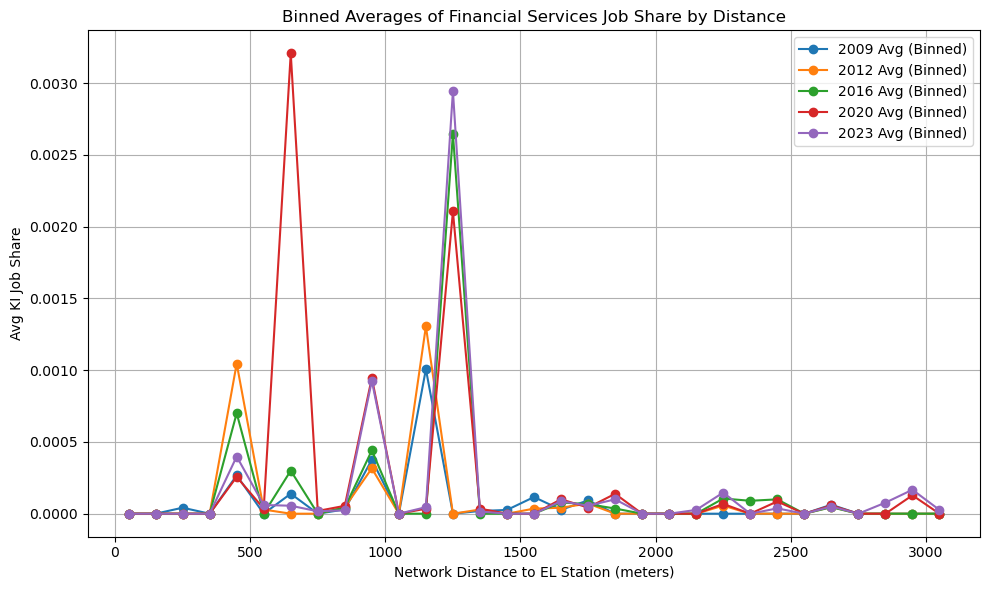

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(bin_avg['bin_mid'], bin_avg['share_09'], 'o-', label='2009 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['share_12'], 'o-', label='2012 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['share_16'], 'o-', label='2016 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['share_20'], 'o-', label='2020 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['share_23'], 'o-', label='2023 Avg (Binned)')
plt.xlabel('Network Distance to EL Station (meters)')
plt.ylabel('Avg KI Job Share')
plt.title('Binned Averages of Financial Services Job Share by Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
bin_edges = list(range(0, 3200, 100))
lsoa_ncaz['distance_bin'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

bin_avg = lsoa_ncaz.groupby('distance_bin')[['count_09', 'count_12', 'count_16', 'count_20', 'count_23']].mean().reset_index()
bin_avg['bin_mid'] = bin_avg['distance_bin'].apply(lambda x: x.mid if pd.notnull(x) else None)

/tmp/ipykernel_3654/2948280160.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = lsoa_ncaz.groupby('distance_bin')[['count_09', 'count_12', 'count_16', 'count_20', 'count_23']].mean().reset_index()


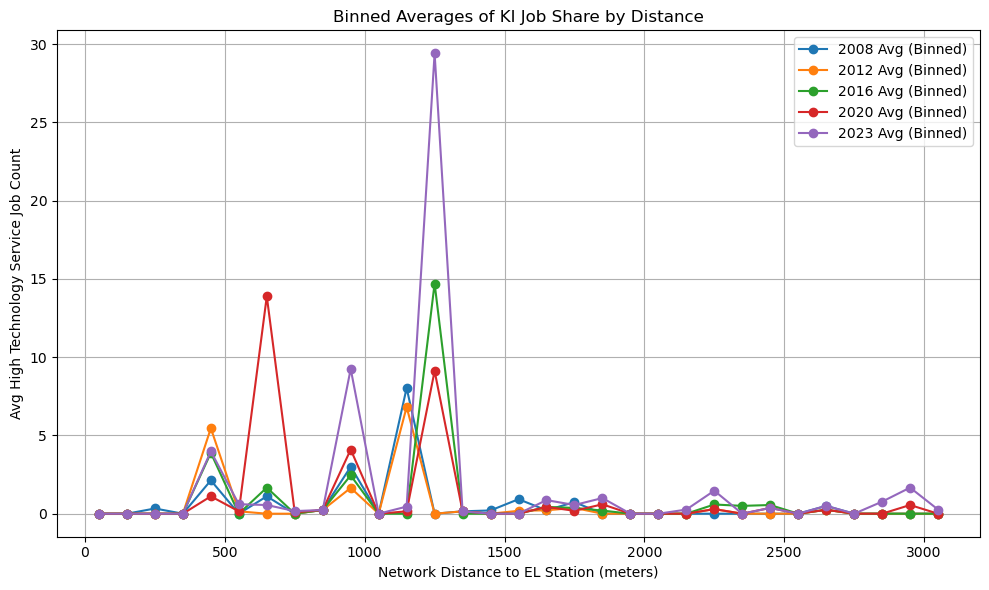

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(bin_avg['bin_mid'], bin_avg['count_09'], 'o-', label='2008 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['count_12'], 'o-', label='2012 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['count_16'], 'o-', label='2016 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['count_20'], 'o-', label='2020 Avg (Binned)')
plt.plot(bin_avg['bin_mid'], bin_avg['count_23'], 'o-', label='2023 Avg (Binned)')
plt.xlabel('Network Distance to EL Station (meters)')
plt.ylabel('Avg High Technology Service Job Count')
plt.title('Binned Averages of KI Job Share by Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3654/2214434888.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = long_df.groupby(['distance_band', 'year'])['share'].mean().reset_index()


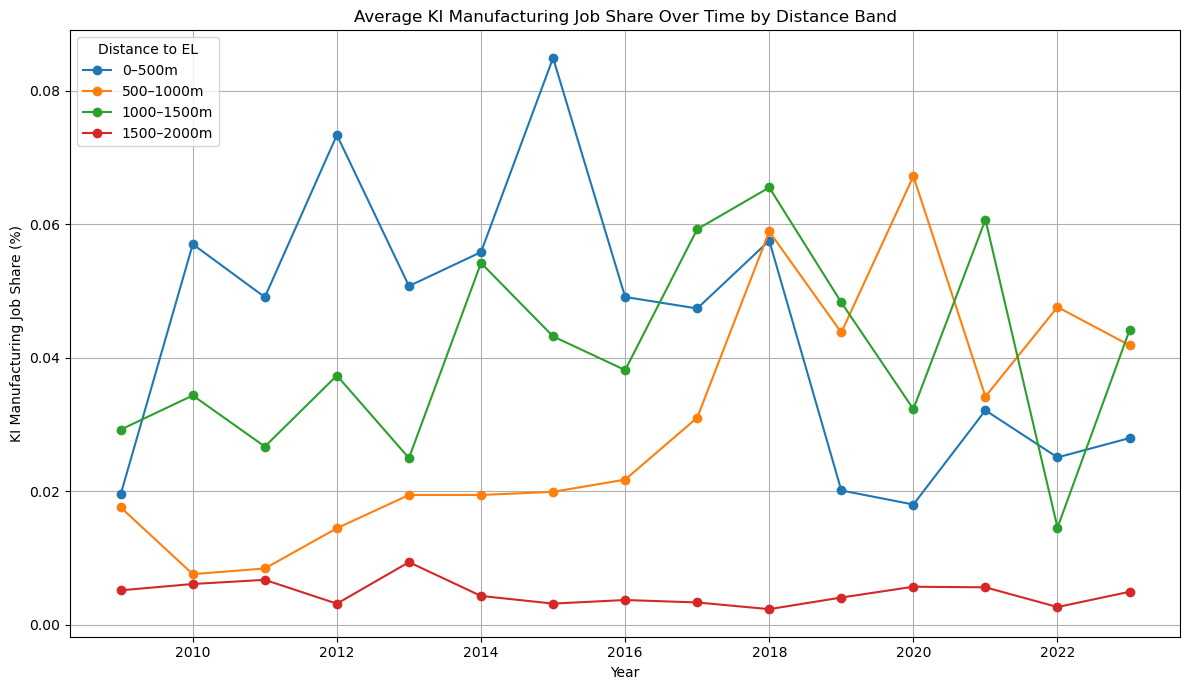

In [61]:
# Define distance bands (reused if already done)
bin_edges = [0, 500, 1000, 1500, 2000]
lsoa_ncaz['distance_band'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

# Melt to long format
share_cols = sorted([col for col in lsoa_ncaz.columns if col.startswith('share_')])
long_df = lsoa_ncaz[['distance_band'] + share_cols].melt(
    id_vars='distance_band',
    value_vars=share_cols,
    var_name='year',
    value_name='share'
)
long_df['year'] = long_df['year'].str.extract(r'share_(\d+)')[0].astype(int) + 2000
long_df = long_df.dropna()

# Group by distance band and year
avg_df = long_df.groupby(['distance_band', 'year'])['share'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))
for band in avg_df['distance_band'].dropna().unique():
    band_data = avg_df[avg_df['distance_band'] == band]
    label = f"{int(band.left)}–{int(band.right)}m"
    plt.plot(band_data['year'], band_data['share'] * 100, label=label, marker='o')

plt.xlabel("Year")
plt.ylabel("KI Manufacturing Job Share (%)")
plt.title("Average KI Manufacturing Job Share Over Time by Distance Band")
plt.legend(title="Distance to EL", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3654/1095872459.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = long_df.groupby(['distance_band', 'year'])['count'].mean().reset_index()


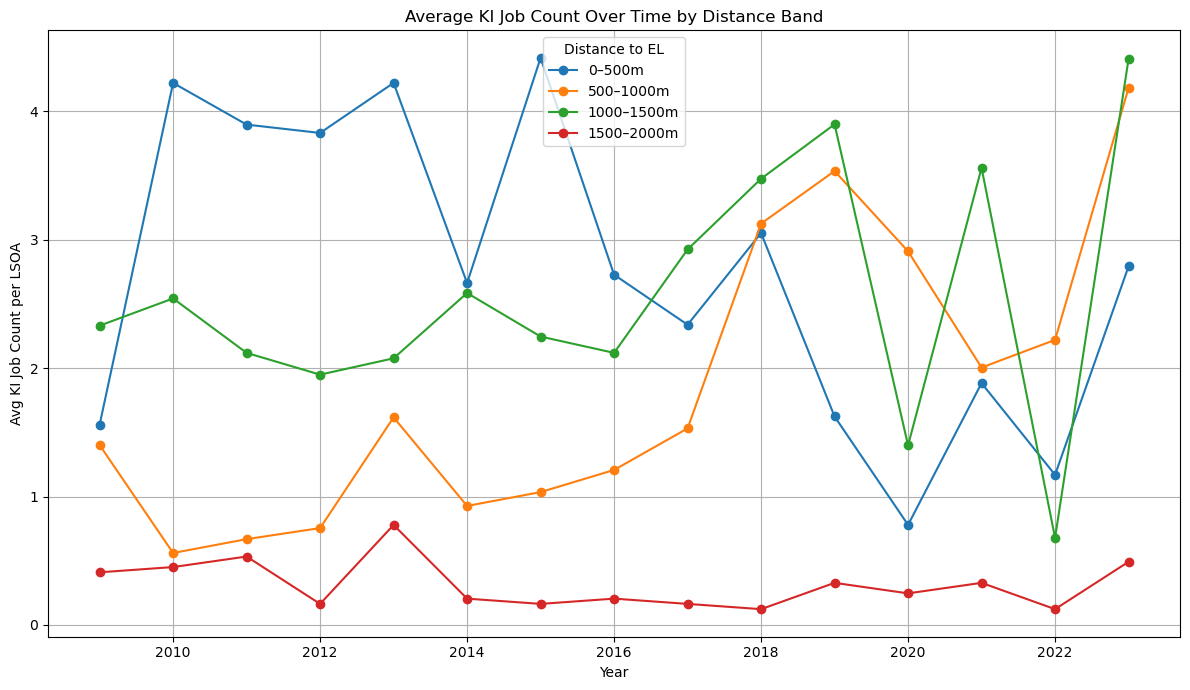

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define distance bands
bin_edges = [0, 500, 1000, 1500, 2000]
lsoa_ncaz['distance_band'] = pd.cut(lsoa_ncaz['network_distance_to_EL'], bins=bin_edges)

# Melt to long format
count_cols = sorted([col for col in lsoa_ncaz.columns if col.startswith('count_')])
long_df = lsoa_ncaz[['distance_band'] + count_cols].melt(
    id_vars='distance_band',
    value_vars=count_cols,
    var_name='year',
    value_name='count'
)
long_df['year'] = long_df['year'].str.extract(r'count_(\d+)')[0].astype(int) + 2000
long_df = long_df.dropna()

# Group by distance band and year
avg_df = long_df.groupby(['distance_band', 'year'])['count'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))
for band in avg_df['distance_band'].dropna().unique():
    band_data = avg_df[avg_df['distance_band'] == band]
    label = f"{int(band.left)}–{int(band.right)}m"
    plt.plot(band_data['year'], band_data['count'], label=label, marker='o')

plt.xlabel("Year")
plt.ylabel("Avg KI Job Count per LSOA")
plt.title("Average KI Job Count Over Time by Distance Band")
plt.legend(title="Distance to EL")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))  # optional: comma formatting
plt.grid(True)
plt.tight_layout()
plt.show()

**Network-based Distance Visual**

In [63]:
# Find Stratford geometry
stratford_geom = crossrail_stations_ncaz_ncw[crossrail_stations_ncaz_ncw['name'] == 'Stratford'].geometry.values[0]

# Find nearest node in the graph
from shapely.ops import nearest_points
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point

# All graph nodes as GeoSeries
graph_nodes = gpd.GeoSeries({node: Point(data['x'], data['y']) for node, data in london_walk_ncaz_ncw.nodes(data=True)}, crs="EPSG:27700")

# Find closest node
nearest_node = graph_nodes.distance(stratford_geom).sort_values().index[0]


In [64]:
# Get all distances from Stratford
lengths = nx.single_source_dijkstra_path_length(london_walk_ncaz_ncw, nearest_node, cutoff=1000, weight='length')


In [65]:
# Ensure LSOAs are in same CRS and compute centroids
lsoa_ncaz = lsoa_ncaz.to_crs("EPSG:27700")
lsoa_ncaz['centroid'] = lsoa_ncaz.geometry.centroid

# Find nearest node for each LSOA centroid
def nearest_node_for_point(point, node_geoms):
    return node_geoms.distance(point).sort_values().index[0]

lsoa_ncaz['nearest_node'] = lsoa_ncaz['centroid'].apply(lambda pt: nearest_node_for_point(pt, graph_nodes))

# Flag LSOAs whose nearest node is within 1000m of Stratford
lsoa_ncaz['within_1000m'] = lsoa_ncaz['nearest_node'].isin(lengths.keys())


In [ ]:
import matplotlib.pyplot as plt
from networkx import ego_graph

# Step 1: Reduce the network to 1000m radius from Stratford
G_sub = ego_graph(london_walk_ncaz_ncw, nearest_node, radius=1000, distance='length')

# Step 2: Pre-filter only relevant LSOAs
within = lsoa_ncaz[lsoa_ncaz['within_1000m']].copy()
within['geometry'] = within.geometry.simplify(tolerance=10)  # Increase tolerance here

# Step 3: Set up the figure
fig, ax = plt.subplots(figsize=(12, 10))

# Step 4: Plot the subnetwork (edges only)
pos_sub = {n: (d['x'], d['y']) for n, d in G_sub.nodes(data=True)}
nx.draw_networkx_edges(G_sub, pos=pos_sub, edge_color='lightgrey', ax=ax, width=0.3)

# Step 5: Plot filtered and simplified LSOAs
within.plot(ax=ax, facecolor='orange', edgecolor='black', alpha=0.5)

# Step 6: Plot Stratford station
gpd.GeoSeries([stratford_geom], crs="EPSG:27700").plot(ax=ax, color='red', markersize=30)

plt.title("LSOAs within 1000m Network Distance from Stratford")
plt.axis('off')
plt.tight_layout()
plt.show()
